# Import

In [1]:
# Spliceai2023 environment
import pandas as pd
import matplotlib.pyplot as plt
#import utils
import pysam
import seaborn as sns
from pyliftover import LiftOver
from matplotlib_venn import venn2

In [5]:
# Define the parameters used to create the plots
rc = {'figure.figsize':(10,5),
      'axes.facecolor':'white',
      'figure.facecolor':'white',
      'axes.grid' : False,
      'font.size' : 20,    
      'font.sans-serif': 'Arial',
      'font.family': 'sans-serif',
      'svg.fonttype' : 'none' }

# (A) Comparison to GTEx dataset

In [4]:
def convert_to_hg38(file):

    # Function to convert coordinates
    def convert_coordinate(chr, coord):
        converted = []
        converted_coord = lo.convert_coordinate(chr, coord)
        if converted_coord:
            return converted_coord[0][1]
        else:
            return 'NA'
    # Read your file into a DataFrame
    df = pd.read_csv(file,
                    sep='\t',
                    header=None,
                    names=['Gene', 'Paralog', 'Chr', 'Strand', 'TxStart', 'TxEnd', 'hg19ESS', 'hg19EES'])

    # Create a LiftOver object for hg19 to hg38 conversion
    lo = LiftOver('hg19', 'hg38')
        
    for index, row in df.iterrows():
        chr = row['Chr']
        df.at[index, 'TxStart38'] = convert_coordinate(chr, row['TxStart'])
        df.at[index, 'TxEnd38'] = convert_coordinate(chr, row['TxEnd'])
        ESS38 = []
        for coord in row['hg19ESS'].split(',')[:-1]:
            ESS38.append(convert_coordinate(chr, int(coord)))
        ESS38 = ','.join(map(str, ESS38))
        EES38 = []
        for coord in row['hg19EES'].split(',')[:-1]:
            EES38.append(convert_coordinate(chr, int(coord)))
        EES38 = ','.join(map(str, EES38))
        df.at[index, 'hg38ESS'] = ESS38
        df.at[index, 'hg38EES'] = EES38

    df['Chr'] = df['Chr'].str.replace('chr', '')

    return df

# Convert gtex from hg19 to hg38
gtex = convert_to_hg38('../datasets/gtex_dataset.txt')

retina = pd.read_csv('../datasets/retina503.15samples.txt',
                    sep='\t',
                    header=None,
                    names=['Gene', 'Paralog', 'Chr', 'Strand', 'TxStart', 'TxEnd', 'ESS', 'EES'])

/tmp/ipykernel_2706560/2837623225.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'TxEnd38'] = convert_coordinate(chr, row['TxEnd'])
/tmp/ipykernel_2706560/2837623225.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'TxStart38'] = convert_coordinate(chr, row['TxStart'])


In [16]:
# Create a set for TxStart, TxEnt, ESS and EES
def populate_sets_from_dataframe(dataframe, txstart_col, txend_col, ess_col, ees_col):
    txstart_set = set()
    txend_set = set()
    ess_set = set()
    ees_set = set()

    for index, row in dataframe.iterrows():
        txstart_set.add(str(row['Gene'] + ':' + row['Chr']) + ':' + row['Strand'] + ':' + str(row[txstart_col]))
        txend_set.add(str(row['Gene'] + ':' + row['Chr']) + ':' + row['Strand'] + ':' + str(row[txend_col]))

        ess = row[ess_col].rstrip(',').split(',')
        for i in ess:
            ess_set.add(str(row['Gene'] + ':' + row['Chr']) + ':' + row['Strand'] + ':' + str(i))
        ees = row[ees_col].rstrip(',').split(',')
        for i in ees:
            ees_set.add(str(row['Gene'] + ':' + row['Chr']) + ':'+ row['Strand'] + ':' + str(i))

    return txstart_set, txend_set, ess_set, ees_set

retina_txstart, retina_tx_end, retina_ess, retina_ees = populate_sets_from_dataframe(
    retina, 'TxStart', 'TxEnd', 'ESS', 'EES')

gtex_txstart, gtex_tx_end, gtex_ess, gtex_ees = populate_sets_from_dataframe(
    gtex, 'TxStart38', 'TxEnd38', 'hg38ESS', 'hg38EES')

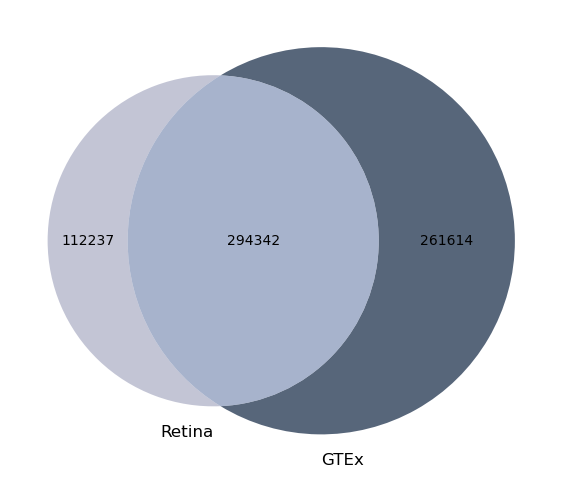

In [17]:

retina_ss = retina_ess.union(retina_ees)
gtex_ss = gtex_ess.union(gtex_ees)

rc = {'figure.figsize':(7,7)}
plt.rcParams.update(rc)

# Create a Venn diagram
venn2(subsets=(len(retina_ss - gtex_ss), len(gtex_ss - retina_ss), len(retina_ss & gtex_ss)),
      set_labels=('Retina', 'GTEx'), set_colors=('#AAADC4', '#102542'), alpha = 0.7)

# Display the diagram
plt.savefig('Trainingdata_overlapwithgtex.svg',  bbox_inches='tight', dpi = 300)
plt.show()


In [19]:
112237/(112237+294342)

0.27605213254988575

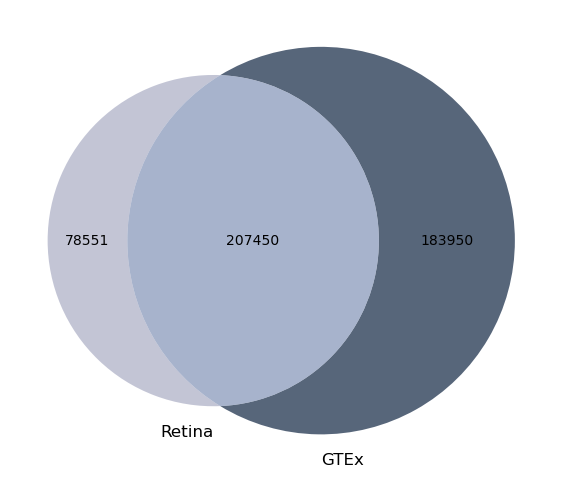

In [18]:
# Create the same plot for splice junction on the training chromosomes
train_chr = ['2', '4', '6', '8', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', 'X', 'Y']

retina_train = retina[retina['Chr'].isin(train_chr)]
gtex_train = gtex[gtex['Chr'].isin(train_chr)]

retina_txstart_train, retina_tx_end_train, retina_ess_train, retina_ees_train = populate_sets_from_dataframe(
    retina_train, 'TxStart', 'TxEnd', 'ESS', 'EES')

gtex_txstart_train, gtex_tx_end_train, gtex_ess_train, gtex_ees_train = populate_sets_from_dataframe(
    gtex_train, 'TxStart38', 'TxEnd38', 'hg38ESS', 'hg38EES')


retina_ss_train = retina_ess_train.union(retina_ees_train)
gtex_ss_train = gtex_ess_train.union(gtex_ees_train)

rc = {'figure.figsize':(7,7)}
plt.rcParams.update(rc)

# Create a Venn diagram
venn2(subsets=(len(retina_ss_train - gtex_ss_train), len(gtex_ss_train - retina_ss_train), len(retina_ss_train & gtex_ss_train)),
      set_labels=('Retina', 'GTEx'), set_colors=('#AAADC4', '#102542'), alpha = 0.7)

# Display the diagram
plt.savefig('Trainingdata_overlapwithgtex_trainchr.svg',  bbox_inches='tight', dpi = 300)
plt.show()

In [20]:
78551/(78551+207450)

0.27465288582907055